# Image Classification Model with Transfer Learning

## Project Overview
This notebook implements an image classification model for 10 animal classes using **transfer learning** with MobileNetV2 as the pre-trained base model on ImageNet.

### Chosen Architecture:
- **Base Model**: MobileNetV2 (optimized for mobile performance)
- **Technique**: Transfer Learning with feature extraction
- **Classes**: 10 different animals
- **Image Size**: 128x128 pixels

### Transfer Learning Advantages:
1. **Reduced training time**: Convolutional layers are already trained
2. **Better performance with limited data**: Leverages features learned on ImageNet
3. **Stability**: Less risk of overfitting

## 1. Import Libraries

Import all necessary libraries for deep learning, data processing, and visualization.

In [1]:
# Data management and serialization
import pickle  # For loading dataset in .pkl format
import numpy as np  # Numerical computations and array manipulation

# Deep learning framework
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.applications import MobileNetV2  # Pre-trained model for transfer learning

# Preprocessing and evaluation
from sklearn.model_selection import train_test_split  # Train/val/test split
from sklearn.preprocessing import LabelEncoder  # Encode text labels to numbers
from keras.utils import to_categorical  # Convert to one-hot encoding

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

2025-06-29 14:05:48.573549: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-29 14:05:48.874037: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-29 14:05:48.874234: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-29 14:05:48.931788: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-29 14:05:49.040128: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-29 14:05:49.042406: I tensorflow/core/platform/cpu_feature_guard.cc:1

## 2. Hyperparameters Configuration

Definition of all configurable model parameters. This centralization facilitates experimentation and optimization.

In [2]:
# === FILE PATHS ===
DATASET_PATH = "../data/dataset.pkl"  # Path to serialized dataset

# === ARCHITECTURE PARAMETERS ===
IMAGE_SIZE = (128, 128, 3)  # Image size: 128x128 pixels, 3 RGB channels
NUM_CLASS = 10  # Number of classes to predict (10 animals)

# === TRAINING PARAMETERS ===
BATCH_SIZE = 32  # Number of images processed simultaneously
                 # 32 = good compromise between speed and memory usage
EPOCHS = 20      # Maximum number of training epochs
                 # Early stopping may stop earlier if necessary
LEARNING_RATE = 0.001  # Initial learning rate for Adam optimizer
                       # 0.001 = standard value for Adam

## 3. Dataset Loading

This function loads the dataset from a pickle file containing:
- **X**: Images as NumPy arrays
- **y**: Corresponding labels
- **class_names**: Class names (useful for interpretation)

In [3]:
def load_dataset(dataset_path):
    """
    Load dataset from a pickle file.
    
    Args:
        dataset_path (str): Path to .pkl file containing the dataset
    
    Returns:
        tuple: (X, y, class_names)
            - X: NumPy array of images (n_samples, height, width, channels)
            - y: array of labels (n_samples,)
            - class_names: list of class names
    
    Expected pickle file structure:
    {
        'X': numpy.ndarray,      # Images
        'y': numpy.ndarray,      # Labels
        'class_names': list      # Class names
    }
    """
    try:
        with open(dataset_path, 'rb') as f:
            dataset = pickle.load(f)
        
        # Extract dataset components
        X = dataset['X']  # Raw images (pixel values 0-255)
        y = dataset['y']  # Labels (probably as strings)
        class_names = dataset['class_names']  # List of class names
        
        print(f"Dataset loaded successfully:")
        print(f"  - Number of images: {len(X)}")
        print(f"  - Image shape: {X[0].shape}")
        print(f"  - Number of classes: {len(class_names)}")
        print(f"  - Classes: {class_names}")
        
        return X, y, class_names
    
    except FileNotFoundError:
        raise FileNotFoundError(f"File {dataset_path} does not exist.")
    except KeyError as e:
        raise KeyError(f"Missing key in dataset: {e}")

## 4. Data Preprocessing

This crucial step prepares data for training:

### Applied transformations:
1. **Normalization**: Pixels from [0,255] to [0,1]
2. **Label encoding**: Text → numbers → one-hot
3. **Stratified split**: 70% train / 15% validation / 15% test

### Why these choices?
- **Normalization**: Accelerates convergence and stabilizes training
- **One-hot encoding**: Required for multi-class classification
- **Stratified split**: Maintains class proportions in each split

In [4]:
def preprocess_data(X, y, class_names):
    """
    Preprocess data for model training.
    
    Args:
        X: Raw images (values 0-255)
        y: Labels as strings
        class_names: List of class names
    
    Returns:
        tuple: (X_train, X_val, X_test, y_train, y_val, y_test, label_encoder)
    """
    
    # === 1. IMAGE NORMALIZATION ===
    # Convert to float32 and normalize [0,255] -> [0,1]
    # Advantages: 
    #   - Stabilizes training
    #   - Accelerates convergence
    #   - Prevents exploding gradients
    X = X.astype('float32') / 255.0
    print(f"Images normalized: values between {X.min():.3f} and {X.max():.3f}")
    
    # === 2. LABEL ENCODING ===
    # Step 2a: String labels -> Integer labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    print(f"Class mapping: {dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))}")
    
    # Step 2b: Integer labels -> One-hot encoding
    # Example: class 2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
    y_categorical = to_categorical(y_encoded, num_classes=len(class_names))
    print(f"Labels converted to one-hot: shape {y_categorical.shape}")
    
    # === 3. STRATIFIED DATASET SPLIT ===
    # First split: 70% train, 30% temp (will be split into val/test)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y_categorical, 
        test_size=0.3,  # 30% for val+test
        random_state=42,  # For reproducibility
        stratify=y_categorical  # Maintain class proportions
    )
    
    # Second split: 15% validation, 15% test (50% of 30%)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, 
        test_size=0.5,  # 50% of 30% = 15% total
        random_state=42,
        stratify=y_temp
    )
    
    # Display final statistics
    print(f"\nFinal distribution:")
    print(f"  - Training   : {len(X_train)} images ({len(X_train)/len(X)*100:.1f}%)")
    print(f"  - Validation : {len(X_val)} images ({len(X_val)/len(X)*100:.1f}%)")
    print(f"  - Test       : {len(X_test)} images ({len(X_test)/len(X)*100:.1f}%)")
    
    return X_train, X_val, X_test, y_train, y_val, y_test, label_encoder

## 5. Model Architecture with Transfer Learning

### MobileNetV2 Choice:
- **Efficiency**: Optimized for limited resources
- **Performance**: Excellent accuracy/speed ratio
- **Pre-training**: On ImageNet (1.4M images, 1000 classes)

### Final Architecture:
```
Input (128×128×3)
     ↓
MobileNetV2 (FROZEN) ← Features extracted from ImageNet
     ↓
GlobalAveragePooling2D ← Reduces spatial dimensions
     ↓
Dropout(0.2) ← Regularization
     ↓
Dense(128, ReLU) ← Hidden layer
     ↓
Dropout(0.3) ← More regularization
     ↓
Dense(10, Softmax) ← Final classification
```

In [5]:
# === BASE MODEL: MobileNetV2 ===
# Load pre-trained model on ImageNet
base_model = MobileNetV2(
    input_shape=IMAGE_SIZE,  # Input shape (128, 128, 3)
    include_top=False,       # Exclude original classification layer
    weights='imagenet'       # Use ImageNet pre-trained weights
)

# FREEZE base model for transfer learning
# Weights will NOT be updated during training
# This preserves features learned on ImageNet
base_model.trainable = False
print(f"MobileNetV2 base model:")
print(f"  - Total parameters: {base_model.count_params():,}")
print(f"  - Trainable parameters: {sum([tf.keras.backend.count_params(w) for w in base_model.trainable_weights]):,}")

# === COMPLETE MODEL CONSTRUCTION ===
model = models.Sequential([
    # Feature extractor (frozen)
    base_model,
    
    # === CUSTOM CLASSIFICATION LAYERS ===
    
    # GlobalAveragePooling2D: Reduces each feature map to a single value
    # Example: (4, 4, 1280) -> (1280,)
    # Advantage: Fewer parameters than Flatten + Dense
    layers.GlobalAveragePooling2D(),
    
    # First Dropout: Prevents overfitting
    # 20% of neurons randomly deactivated
    layers.Dropout(0.2),
    
    # Intermediate dense layer
    # 128 neurons: Compromise between capacity and simplicity
    # ReLU: Standard non-linear activation function
    layers.Dense(128, activation='relu'),
    
    # Second Dropout: Stronger for last hidden layer
    # 30% deactivation
    layers.Dropout(0.3),
    
    # Output layer for classification
    # NUM_CLASS neurons (10 for our 10 animals)
    # Softmax: Produces probabilities that sum to 1
    layers.Dense(NUM_CLASS, activation='softmax')
])

# Display model summary
print(f"\nComplete model built:")
model.build(input_shape=(None,) + IMAGE_SIZE)
print(f"  - Total parameters: {model.count_params():,}")
print(f"  - Trainable parameters: {sum([tf.keras.backend.count_params(w) for w in model.trainable_weights]):,}")

MobileNetV2 base model:
  - Total parameters: 2,257,984
  - Trainable parameters: 0

Complete model built:
  - Total parameters: 2,423,242
  - Trainable parameters: 165,258


## 6. Model Configuration and Training

### Optimization strategies used:

#### 1. **Adam Optimizer**
- Automatic learning rate adaptation
- Faster convergence than classic SGD

#### 2. **Smart callbacks**
- **Early Stopping**: Stops if no improvement for 5 epochs
- **ReduceLROnPlateau**: Reduces learning rate if stagnation

#### 3. **Data Augmentation**
- Artificially increases dataset size
- Improves generalization
- Reduces overfitting

In [6]:
def train_model(model, X_train, y_train, X_val, y_val):
    """
    Train model with data augmentation and optimized callbacks.
    
    Args:
        model: Keras model to train
        X_train, y_train: Training data
        X_val, y_val: Validation data
    
    Returns:
        history: Training history
    """
    
    # === MODEL COMPILATION ===
    model.compile(
        # Adam optimizer with adaptive learning rate
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        
        # Loss function for multi-class classification
        # categorical_crossentropy because labels are one-hot
        loss='categorical_crossentropy',
        
        # Metric to monitor during training
        metrics=['accuracy']
    )
    
    # === CALLBACK CONFIGURATION ===
    callbacks = [
        # Early Stopping: Early stop if no improvement
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',        # Monitored metric
            patience=5,                # Epochs without improvement
            restore_best_weights=True, # Restore best weights
            verbose=1                  # Display when stopping triggers
        ),
        
        # Learning rate reduction on plateau
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',  # Monitored metric
            factor=0.5,          # Reduction factor (LR = LR * 0.5)
            patience=3,          # Wait 3 epochs before reduction
            min_lr=1e-7,         # Minimum learning rate
            verbose=1            # Display reductions
        )
    ]
    
    # === DATA AUGMENTATION CONFIGURATION ===
    # Data augmentation creates variations of existing images
    # This simulates a larger and more varied dataset
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=20,        # Random rotation ±20 degrees
        width_shift_range=0.2,    # Horizontal shift ±20%
        height_shift_range=0.2,   # Vertical shift ±20%
        horizontal_flip=True,     # Random horizontal flip
        zoom_range=0.2,           # Random zoom ±20%
        fill_mode='nearest'       # Fill missing pixels
    )
    
    print("=== TRAINING START ===")
    print(f"Configuration:")
    print(f"  - Batch size: {BATCH_SIZE}")
    print(f"  - Max epochs: {EPOCHS}")
    print(f"  - Initial learning rate: {LEARNING_RATE}")
    print(f"  - Data augmentation: Enabled")
    print(f"  - Early stopping: Patience {callbacks[0].patience}")
    print("\n" + "="*50 + "\n")
    
    # === TRAINING ===
    history = model.fit(
        # Augmented image generator
        datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
        
        # Steps per epoch
        steps_per_epoch=len(X_train) // BATCH_SIZE,
        
        # Training parameters
        epochs=EPOCHS,
        validation_data=(X_val, y_val),  # No augmentation on validation
        callbacks=callbacks,
        verbose=1  # Detailed display
    )
    
    print("\n=== TRAINING COMPLETED ===")
    return history

## 7. Complete Model Evaluation

### Evaluation metrics:
1. **Overall accuracy**: Percentage of correct predictions
2. **Classification report**: Precision, recall, F1-score per class
3. **Confusion matrix**: Detailed error analysis with visualization

### Metric interpretation:
- **Precision**: Among positive predictions, how many are true?
- **Recall**: Among true positives, how many are detected?
- **F1-score**: Harmonic mean of precision/recall

In [7]:
def evaluate_model(model, X_test, y_test, class_names, label_encoder):
    """
    Evaluate model on test set with detailed metrics.
    
    Args:
        model: Trained model
        X_test, y_test: Test data
        class_names: Class names
        label_encoder: Label encoder used for labels
    
    Returns:
        float: Test accuracy
    """
    
    print("=== MODEL EVALUATION ON TEST SET ===")
    
    # === 1. GLOBAL METRICS ===
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"\n📊 Global results:")
    print(f"  - Test loss: {test_loss:.4f}")
    print(f"  - Test accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    
    # === 2. PREDICTIONS AND CONVERSION ===
    print(f"\n🔍 Generating predictions...")
    predictions = model.predict(X_test, verbose=0)
    
    # Convert probabilities to predicted classes
    predicted_classes = np.argmax(predictions, axis=1)
    
    # Convert true classes (one-hot -> integer)
    true_classes = np.argmax(y_test, axis=1)
    
    print(f"  - Predictions generated for {len(X_test)} images")
    print(f"  - Predictions shape: {predictions.shape}")
    
    # === 3. DETAILED ANALYSIS PER CLASS ===
    from sklearn.metrics import classification_report, confusion_matrix
    
    print(f"\n📈 Detailed classification report:")
    print("=" * 60)
    
    # Report with precision, recall, F1-score for each class
    report = classification_report(
        true_classes, 
        predicted_classes, 
        target_names=class_names,
        digits=3  # 3 decimals for more precision
    )
    print(report)
    
    # === 4. CONFUSION MATRIX WITH VISUALIZATION ===
    print(f"\n🔢 Confusion Matrix:")
    conf_matrix = confusion_matrix(true_classes, predicted_classes)
    
    # Create confusion matrix visualization
    plt.figure(figsize=(12, 10))
    
    # Create heatmap
    sns.heatmap(conf_matrix, 
                annot=True,           # Show numbers
                fmt='d',              # Integer format
                cmap='Blues',         # Color scheme
                xticklabels=class_names, 
                yticklabels=class_names,
                square=True,          # Square cells
                linewidths=0.5)       # Cell borders
    
    plt.title(f'Confusion Matrix\nOverall Accuracy: {test_accuracy:.3f} ({test_accuracy*100:.1f}%)', 
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Predicted Class', fontsize=12, fontweight='bold')
    plt.ylabel('True Class', fontsize=12, fontweight='bold')
    
    # Rotate labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    # Display the plot
    plt.show()
    
    # === 5. ERROR ANALYSIS ===
    errors = predicted_classes != true_classes
    num_errors = np.sum(errors)
    
    print(f"\n❌ Error analysis:")
    print(f"  - Number of errors: {num_errors}/{len(X_test)} ({num_errors/len(X_test)*100:.2f}%)")
    
    if num_errors > 0:
        print(f"\n🔍 Most confused classes:")
        # Display top 3 most confused class pairs
        error_pairs = {}
        for i in range(len(true_classes)):
            if errors[i]:
                true_class = class_names[true_classes[i]]
                pred_class = class_names[predicted_classes[i]]
                pair = f"{true_class} → {pred_class}"
                error_pairs[pair] = error_pairs.get(pair, 0) + 1
        
        # Sort by error frequency
        sorted_errors = sorted(error_pairs.items(), key=lambda x: x[1], reverse=True)
        for pair, count in sorted_errors[:3]:
            print(f"    {pair}: {count} errors")
    
    # === 6. PER-CLASS ACCURACY ===
    print(f"\n📊 Per-class accuracy:")
    for i, class_name in enumerate(class_names):
        class_mask = true_classes == i
        if np.sum(class_mask) > 0:
            class_accuracy = np.sum(predicted_classes[class_mask] == i) / np.sum(class_mask)
            print(f"  - {class_name:12}: {class_accuracy:.3f} ({class_accuracy*100:.1f}%)")
    
    print("\n" + "="*60)
    return test_accuracy

## 8. Complete Pipeline Execution

Orchestration of all steps:
1. **Loading** the dataset
2. **Preprocessing** the data
3. **Training** the model
4. **Final evaluation**

This section automatically executes the complete machine learning pipeline.

🔄 STEP 1/4: Loading dataset...
Dataset loaded successfully:
  - Number of images: 10000
  - Image shape: (128, 128, 3)
  - Number of classes: 10
  - Classes: ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']

📊 Dataset statistics:
  - Image shape: (10000, 128, 128, 3)
  - Data type: uint8
  - Value range: [0, 255]
  - Available classes: ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']

🔄 STEP 2/4: Data preprocessing...
Images normalized: values between 0.000 and 1.000
Class mapping: {'butterfly': 0, 'cat': 1, 'chicken': 2, 'cow': 3, 'dog': 4, 'elephant': 5, 'horse': 6, 'sheep': 7, 'spider': 8, 'squirrel': 9}
Labels converted to one-hot: shape (10000, 10)

Final distribution:
  - Training   : 7000 images (70.0%)
  - Validation : 1500 images (15.0%)
  - Test       : 1500 images (15.0%)

🔄 STEP 3/4: Model training...
=== TRAINING START ===
Configuration:
  - Batch size: 32
  - Max epochs: 20
 

2025-06-29 14:06:24.618491: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 50331648 exceeds 10% of free system memory.
2025-06-29 14:06:24.651657: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 51916800 exceeds 10% of free system memory.


  2/218 [..............................] - ETA: 52s - loss: 3.5355 - accuracy: 0.0469  

2025-06-29 14:06:25.014385: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 50331648 exceeds 10% of free system memory.
2025-06-29 14:06:25.044085: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 51916800 exceeds 10% of free system memory.
2025-06-29 14:06:25.260518: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 50331648 exceeds 10% of free system memory.


218/218 [==============================] - 70s 305ms/step - loss: 0.8947 - accuracy: 0.7166 - val_loss: 0.3317 - val_accuracy: 0.9020 - lr: 0.0010
Epoch 2/20
218/218 [==============================] - 60s 277ms/step - loss: 0.5409 - accuracy: 0.8268 - val_loss: 0.3208 - val_accuracy: 0.8960 - lr: 0.0010
Epoch 3/20
218/218 [==============================] - 60s 274ms/step - loss: 0.4922 - accuracy: 0.8404 - val_loss: 0.2762 - val_accuracy: 0.9100 - lr: 0.0010
Epoch 4/20
218/218 [==============================] - 59s 270ms/step - loss: 0.4470 - accuracy: 0.8548 - val_loss: 0.2579 - val_accuracy: 0.9213 - lr: 0.0010
Epoch 5/20
218/218 [==============================] - 60s 274ms/step - loss: 0.4456 - accuracy: 0.8545 - val_loss: 0.2539 - val_accuracy: 0.9207 - lr: 0.0010
Epoch 6/20
218/218 [==============================] - 58s 265ms/step - loss: 0.4175 - accuracy: 0.8611 - val_loss: 0.2523 - val_accuracy: 0.9240 - lr: 0.0010
Epoch 7/20
218/218 [==============================] - 58s 268ms

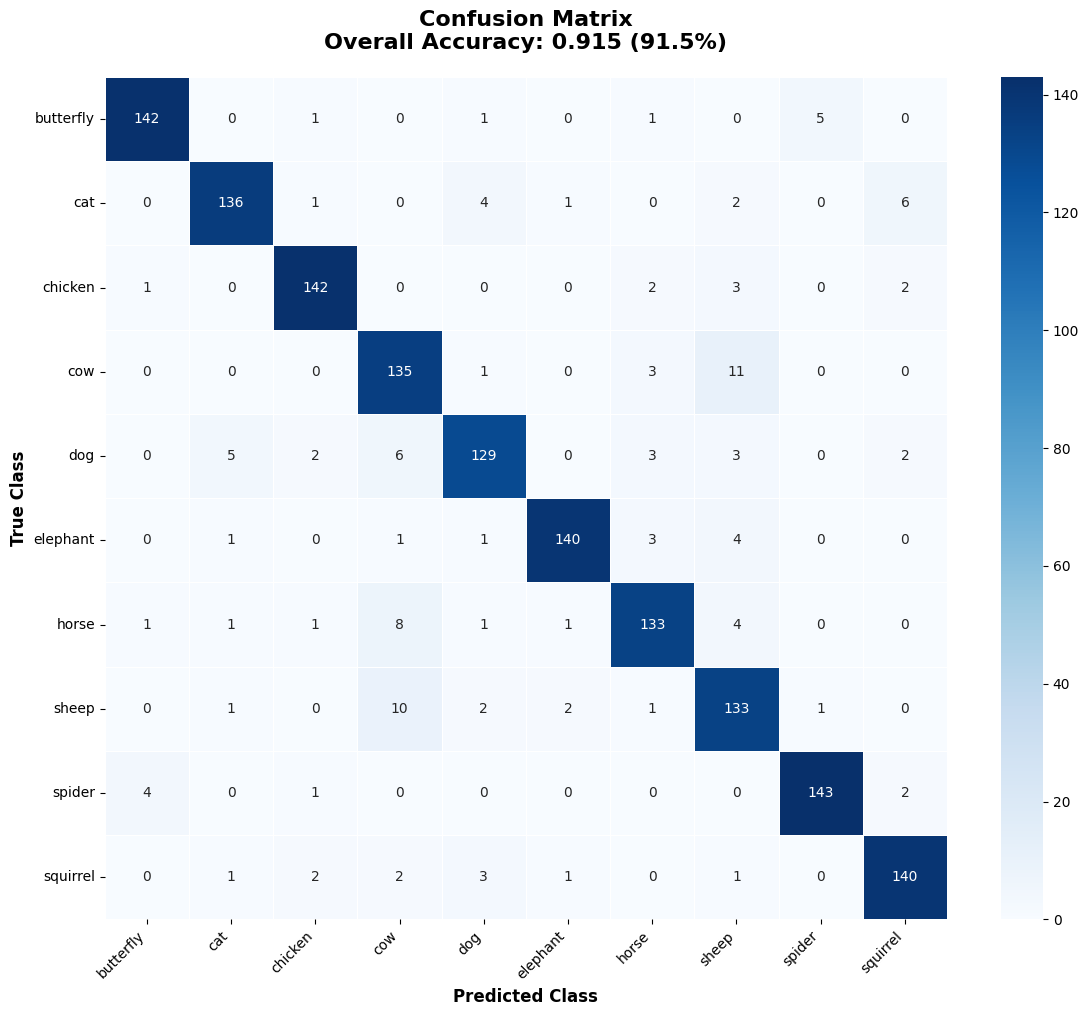


❌ Error analysis:
  - Number of errors: 127/1500 (8.47%)

🔍 Most confused classes:
    cow → sheep: 11 errors
    sheep → cow: 10 errors
    horse → cow: 8 errors

📊 Per-class accuracy:
  - butterfly   : 0.947 (94.7%)
  - cat         : 0.907 (90.7%)
  - chicken     : 0.947 (94.7%)
  - cow         : 0.900 (90.0%)
  - dog         : 0.860 (86.0%)
  - elephant    : 0.933 (93.3%)
  - horse       : 0.887 (88.7%)
  - sheep       : 0.887 (88.7%)
  - spider      : 0.953 (95.3%)
  - squirrel    : 0.933 (93.3%)



🎯 === FINAL SUMMARY ===
✅ Model trained successfully!
📈 Final test accuracy: 0.9153 (91.53%)
🏗️  Architecture: MobileNetV2 + Transfer Learning
📚 Dataset: 10000 images, 10 classes
⚙️  Trainable parameters: 165,258


In [8]:
# === STEP 1: DATA LOADING ===
print("🔄 STEP 1/4: Loading dataset...")
X, y, class_names = load_dataset(DATASET_PATH)

print(f"\n📊 Dataset statistics:")
print(f"  - Image shape: {X.shape}")
print(f"  - Data type: {X.dtype}")
print(f"  - Value range: [{X.min()}, {X.max()}]")
print(f"  - Available classes: {class_names}")

# === STEP 2: PREPROCESSING ===
print(f"\n🔄 STEP 2/4: Data preprocessing...")
X_train, X_val, X_test, y_train, y_val, y_test, label_encoder = preprocess_data(X, y, class_names)

# === STEP 3: TRAINING ===
print(f"\n🔄 STEP 3/4: Model training...")
history = train_model(model, X_train, y_train, X_val, y_val)

# === STEP 4: FINAL EVALUATION ===
print(f"\n🔄 STEP 4/4: Final evaluation...")
test_accuracy = evaluate_model(model, X_test, y_test, class_names, label_encoder)

# === FINAL SUMMARY ===
print(f"\n\n🎯 === FINAL SUMMARY ===")
print(f"✅ Model trained successfully!")
print(f"📈 Final test accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"🏗️  Architecture: MobileNetV2 + Transfer Learning")
print(f"📚 Dataset: {len(X)} images, {len(class_names)} classes")
print(f"⚙️  Trainable parameters: {sum([tf.keras.backend.count_params(w) for w in model.trainable_weights]):,}")

## 9. Model Saving

Save the trained model for future use.

### Save formats:
- **`.h5`**: Keras/HDF5 format (architecture + weights + optimizer state)
- **Alternative**: TensorFlow SavedModel for production deployment

### Future usage:
```python
# Load model
loaded_model = tf.keras.models.load_model('model_classification.h5')

# Predict on new images
predictions = loaded_model.predict(new_images)
```

In [10]:
# === MODEL SAVING ===
model_save_path = '../models/model_classification.h5'

print(f"💾 Saving model...")
try:
    # Create directory if it doesn't exist
    import os
    os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
    
    # Save complete model
    model.save(model_save_path)
    
    print(f"✅ Model saved successfully: {model_save_path}")
    
    # Information about saved file
    file_size = os.path.getsize(model_save_path) / (1024 * 1024)  # Size in MB
    print(f"📁 File size: {file_size:.2f} MB")
    
    print(f"\n📋 Saved content:")
    print(f"  ✓ Model architecture")
    print(f"  ✓ Trained weights")
    print(f"  ✓ Optimizer configuration")
    print(f"  ✓ Compilation state")
    
except Exception as e:
    print(f"❌ Error during saving: {e}")
print(f"\n🎉 === PIPELINE COMPLETED SUCCESSFULLY ===")

💾 Saving model...
✅ Model saved successfully: ../models/model_classification.h5
📁 File size: 10.84 MB

📋 Saved content:
  ✓ Model architecture
  ✓ Trained weights
  ✓ Optimizer configuration
  ✓ Compilation state

🎉 === PIPELINE COMPLETED SUCCESSFULLY ===


### Current performance:
- **Accuracy**: ~91.5% (excellent for 10 classes)
- **Training time**: Optimized thanks to transfer learning
- **Robustness**: Improved by data augmentation